# Wasserstein GAN with Gradient Penalty (WGAN-GP)

This code is based on [_Improved Training of Wasserstein GANs (2017)_](https://arxiv.org/abs/1704.00028) paper by Ishaan Gulrajani, Faruk Ahmed, et all.

![WGAN-GP](https://github.com/threeal/Introduction-to-GAN/raw/master/2%20-%20Wasserstein%20GANs/images/wgan-gp.png)

## Environment Setup

In [1]:
import torch

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using %s" % (device))

using cuda


## Prepare Dataset

In [2]:
from torchvision import datasets, transforms

# setup MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

mnist_dataset = datasets.MNIST(
    root="./datasets", train=True, transform=transform, download=True)

mnist_width = mnist_dataset.train_data.size(1)
mnist_height = mnist_dataset.train_data.size(2)
mnist_shape = [1, mnist_width, mnist_height]

# data loader (input pipeline)
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset, batch_size=100, shuffle=True)

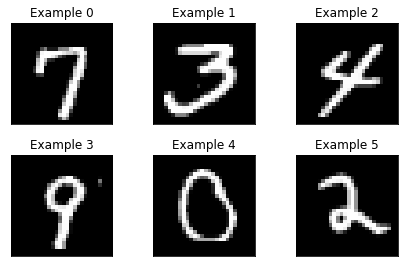

In [3]:
import matplotlib.pyplot as plt

examples = enumerate(data_loader)
_, (example_data, _) = next(examples)

# plot example data
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Example %d" % i)
    plt.xticks([])
    plt.yticks([])

plt.show()

## Build Models

In [4]:
import torch.nn as nn


def nn_block(in_feat, out_feat, normalize=False):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

In [5]:
# generator model
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            *nn_block(in_dim, 128),
            *nn_block(128, 256, normalize=True),
            *nn_block(256, 512, normalize=True),
            *nn_block(512, 1024, normalize=True),
            nn.Linear(1024, out_dim),
            nn.Tanh())

    def forward(self, noise):
        output = self.model(noise)
        image = output.view(output.size(0), *mnist_shape)
        return image

In [6]:
# critic model
class Critic(nn.Module):
    def __init__(self, in_dim):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            *nn_block(in_dim, 512),
            *nn_block(512, 256),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [7]:
noise_dim = 100
mnist_dim = mnist_width * mnist_height

# build model
generator = Generator(in_dim=noise_dim, out_dim=mnist_dim).to(device)
critic = Critic(in_dim=mnist_dim).to(device)

print(generator, critic)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Critic(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2

# Train Process

![WGAN GP Algorithm](https://github.com/threeal/Introduction-to-GAN/raw/master/2%20-%20Wasserstein%20GANs/images/wgan-gp-algorithm.png)

In [8]:
# optimizers
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

c_optimizer = torch.optim.Adam(
    critic.parameters(), lr=0.0002, betas=(0.5, 0.999))

if torch.cuda.is_available():
    FloatTensor = torch.cuda.FloatTensor
else:
    FloatTensor = torch.FloatTensor

In [9]:
import torch.autograd as autograd
from torch.autograd import Variable

# loss weight for gradient penalty
lambda_gp = 10


# calculates the gradient penalty loss for WGAN-GP
def compute_gradient_penalty(critic, real_samples, fake_samples):
    # random weight term for interpolation between real and fake samples
    alpha = FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))

    # get random interpolation between real and fake samples
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.requires_grad_(True)

    c_interpolates = critic(interpolates)
    fake = Variable(FloatTensor(real_samples.shape[0], 1).fill_(1.0),
                    requires_grad=False)

    # get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=c_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [10]:
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import time
import os

start = time.time()

g_losses = []
c_losses = []

epochs = 200
n_critic = 5

# train process
for epoch in range(epochs):

    g_loss_sum = 0
    c_loss_sum = 0

    for i, (imgs, _) in enumerate(data_loader):

        batch_size = imgs.size(0)

        # configure input
        real_imgs = Variable(imgs.type(FloatTensor))

        # --------------
        #  Train Critic
        # --------------

        c_optimizer.zero_grad()

        # sample noise as generator input
        noise = Variable(FloatTensor(
            np.random.normal(0, 1, (batch_size, noise_dim))))

        # generate a batch of images
        gen_imgs = generator(noise)

        # gradient penalty
        gradient_penalty = compute_gradient_penalty(
            critic, real_imgs.data, gen_imgs.detach().data)

        # adversarial loss
        real_loss = torch.mean(critic(real_imgs))
        fake_loss = torch.mean(critic(gen_imgs.detach()))
        c_loss = -real_loss + fake_loss + lambda_gp * gradient_penalty

        c_loss.backward()
        c_optimizer.step()

        # train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            g_optimizer.zero_grad()

            # generate a batch of images
            gen_imgs = generator(noise)

            # adversarial loss
            g_loss = -torch.mean(critic(gen_imgs))
            g_loss_sum += g_loss.item()

            g_loss.backward()
            g_optimizer.step()

        elapsed = time.time() - start
        print("\r[Elapsed %02d:%02d]" % (elapsed // 60, elapsed % 60), end='')

        print(" [Epoch %d/%d] [Batch %d/%d]"
              % (epoch+1, epochs, i+1, len(data_loader)), end='')

        print(" [G loss: %f] [C loss: %f]"
              % (g_loss.item(), c_loss.item()), end='')

    g_losses.append(g_loss_sum / (len(data_loader) / n_critic))
    c_losses.append(c_loss_sum / len(data_loader))

    if (epoch + 1) % 10 == 0:
        # sample noise as generator input
        noise = Variable(FloatTensor(
            np.random.normal(0, 1, (5 * 5, noise_dim))))

        # generate a batch of sample images
        gen_imgs = generator(noise)

        # save sample images
        os.makedirs("./samples/wgan-gp", exist_ok=True)
        save_image(gen_imgs, "./samples/wgan-gp/sample_%03d.png" % (epoch + 1),
                   nrow=5, normalize=True)

# save result models
os.makedirs("./models/wgan-gp", exist_ok=True)
torch.save(generator, "./models/wgan-gp/generator.pt")
torch.save(critic, "./models/wgan-gp/critic.pt")

[Elapsed 40:34] [Epoch 200/200] [Batch 600/600] [G loss: -0.000000] [C loss: 10.000000]

## Train Result

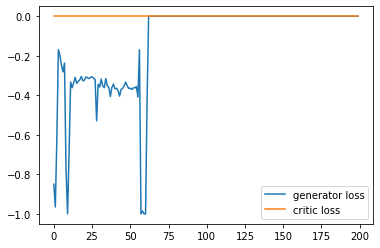

In [11]:
# plot losses
plt.plot(g_losses, label="generator loss")
plt.plot(c_losses, label="critic loss")
plt.legend()
plt.show()

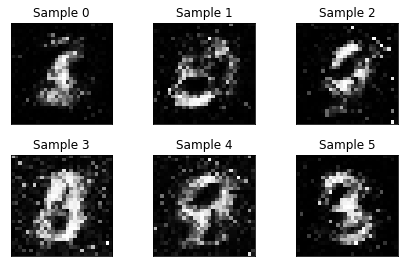

In [12]:
# sample noise as generator input
noise = Variable(FloatTensor(np.random.normal(0, 1, (6, noise_dim))))

# generate a batch of sample images
gen_imgs = generator(noise)

# plot sample images
imgs = gen_imgs.cpu().detach().numpy()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
    plt.title("Sample %d" % i)
    plt.xticks([])
    plt.yticks([])

plt.show()